In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [7]:
from ufc import constants, load_data

In [8]:
# Load data
df = load_data.read_prepped_data()

response = "outcome"

In [69]:
np.random.seed(constants.SEED)

### Functions
Functionalise GBM fit

In [35]:
def test_xgboost(data, features, categorical_features, benchmark_random_feature=True):
    df = data.copy()

    # Encode outcome
    le = LabelEncoder()
    df['outcome'] = le.fit_transform(df['outcome'])
    
    if benchmark_random_feature:
        random_state = np.random.RandomState(constants.SEED)
        df['RANDOM_FEATURE'] = random_state.random(size=data.shape[0])
        features = features + ["RANDOM_FEATURE"]
        
    # One-hot encode categorical features
    # categorical_features = ['weight_class', "fighter1_stance", "fighter2_stance"]
    numeric_features = [col for col in features if col not in categorical_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])
    
    # Split data
    X = df[features]
    y = df[response]

    # Split the data into training, validation, and test sets - 70% / 15% / 15%
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=constants.SEED
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=constants.SEED
    )

    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=constants.SEED)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb_model)
    ])

    # Grid search for best hyperparameters
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 4, 5],
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Errors on validation set
    y_val_pred = best_model.predict(X_val)

    val_metrics = {
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Confusion matrix": confusion_matrix(y_val, y_val_pred),
        "Classification report": classification_report(y_val, y_val_pred),
    }

    # Errors on test set
    y_test_pred = best_model.predict(X_test)

    test_metrics = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Confusion matrix": confusion_matrix(y_test, y_test_pred),
        "Classification report": classification_report(y_test, y_test_pred),
    }

    error_metrics = {
        "Validation": val_metrics,
        "Test": test_metrics
    }

    return best_model, error_metrics, numeric_features



In [36]:
def print_error_metrics(error_metrics):
    print("--- Validation set ---")
    print("Accuracy:", error_metrics["Validation"]["Accuracy"])
    print("Confusion Matrix:\n", error_metrics["Validation"]["Confusion matrix"])
    print("Classification Report:\n", error_metrics["Validation"]["Classification report"])

    print("--- Test set")
    print("Accuracy:", error_metrics["Test"]["Accuracy"])
    print("Confusion Matrix:\n", error_metrics["Test"]["Confusion matrix"])
    print("Classification Report:\n", error_metrics["Test"]["Classification report"])

In [67]:
def plot_feature_importance(xgboost_model, numeric_features):
    feature_importances = xgboost_model.named_steps['classifier'].feature_importances_
    one_hot_encoder = xgboost_model.named_steps['preprocessor'].named_transformers_['cat']
    # Check if any categorical features
    if hasattr(one_hot_encoder, 'categories_'):
        input_features = one_hot_encoder.get_feature_names_out()
    else:
        input_features = []
        
    feature_names = numeric_features + list(input_features)

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    feature_importance_df = feature_importance_df\
        .sort_values(by='Importance', ascending=False)\
        .reset_index(drop=True)

    print(feature_importance_df)

    plt.figure(figsize=(10, 10))

    if 'RANDOM_FEATURE' in feature_names:
        random_feature_index = feature_importance_df[feature_importance_df["Feature"] == "RANDOM_FEATURE"].index
        print(random_feature_index)
        plt.axhline(y=random_feature_index - 0.5, color='k', linestyle='--', label='RANDOM_FEATURE')

    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], align='center')
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()


### Test model iterations
Different feature sets

All features

--- Validation set ---
Accuracy: 0.6388308977035491
Confusion Matrix:
 [[146  90]
 [ 83 160]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.62      0.63       236
           1       0.64      0.66      0.65       243

    accuracy                           0.64       479
   macro avg       0.64      0.64      0.64       479
weighted avg       0.64      0.64      0.64       479

--- Test set
Accuracy: 0.6367432150313153
Confusion Matrix:
 [[160  87]
 [ 87 145]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65       247
           1       0.62      0.62      0.62       232

    accuracy                           0.64       479
   macro avg       0.64      0.64      0.64       479
weighted avg       0.64      0.64      0.64       479

                                     Feature  Importance
0                 delta_sig_strikes_accuracy    0.082449
1     

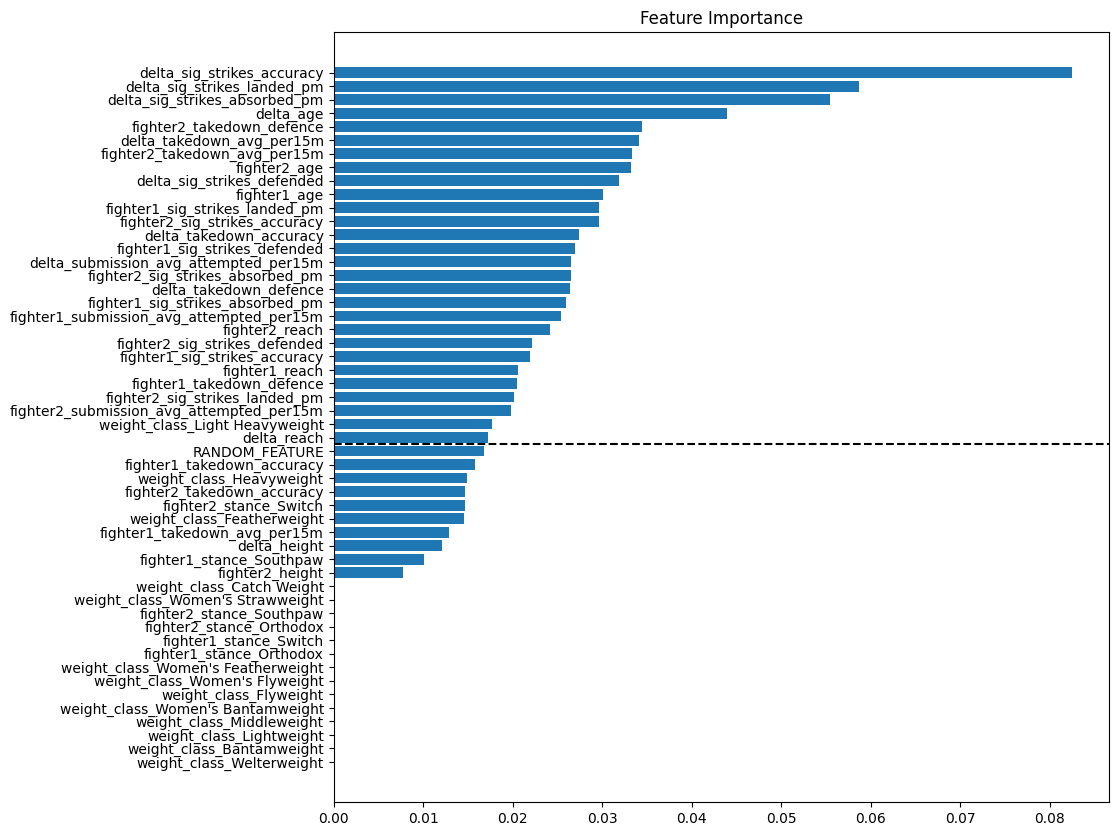

In [68]:
features = [
    'weight_class',
    'fighter1_reach', 'fighter1_stance', 'fighter1_sig_strikes_landed_pm',
    'fighter1_sig_strikes_accuracy', 'fighter1_sig_strikes_absorbed_pm',
    'fighter1_sig_strikes_defended', 'fighter1_takedown_avg_per15m',
    'fighter1_takedown_accuracy', 'fighter1_takedown_defence',
    'fighter1_submission_avg_attempted_per15m', 'fighter2_height',
    'fighter2_reach',
    'fighter2_stance', 'fighter2_sig_strikes_landed_pm',
    'fighter2_sig_strikes_accuracy', 'fighter2_sig_strikes_absorbed_pm',
    'fighter2_sig_strikes_defended', 'fighter2_takedown_avg_per15m',
    'fighter2_takedown_accuracy', 'fighter2_takedown_defence',
    'fighter2_submission_avg_attempted_per15m', 'fighter1_age',
    'fighter2_age', 'delta_height', 'delta_age', 'delta_reach',
    'delta_sig_strikes_landed_pm', 'delta_sig_strikes_accuracy',
    'delta_sig_strikes_absorbed_pm', 'delta_sig_strikes_defended',
    'delta_takedown_avg_per15m', 'delta_takedown_accuracy',
    'delta_takedown_defence', 'delta_submission_avg_attempted_per15m',
]

categorical_features = ['weight_class', "fighter1_stance", "fighter2_stance"]

xgb_model, error_metrics, numeric_features = test_xgboost(
    df, features, categorical_features, benchmark_random_feature=True
)
print_error_metrics(error_metrics)
plot_feature_importance(xgb_model, numeric_features)

Delta features

--- Validation set ---
Accuracy: 0.6430062630480167
Confusion Matrix:
 [[147  89]
 [ 82 161]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.62      0.63       236
           1       0.64      0.66      0.65       243

    accuracy                           0.64       479
   macro avg       0.64      0.64      0.64       479
weighted avg       0.64      0.64      0.64       479

--- Test set
Accuracy: 0.6409185803757829
Confusion Matrix:
 [[154  93]
 [ 79 153]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.62      0.64       247
           1       0.62      0.66      0.64       232

    accuracy                           0.64       479
   macro avg       0.64      0.64      0.64       479
weighted avg       0.64      0.64      0.64       479

                                  Feature  Importance
0              delta_sig_strikes_accuracy    0.129140
1           

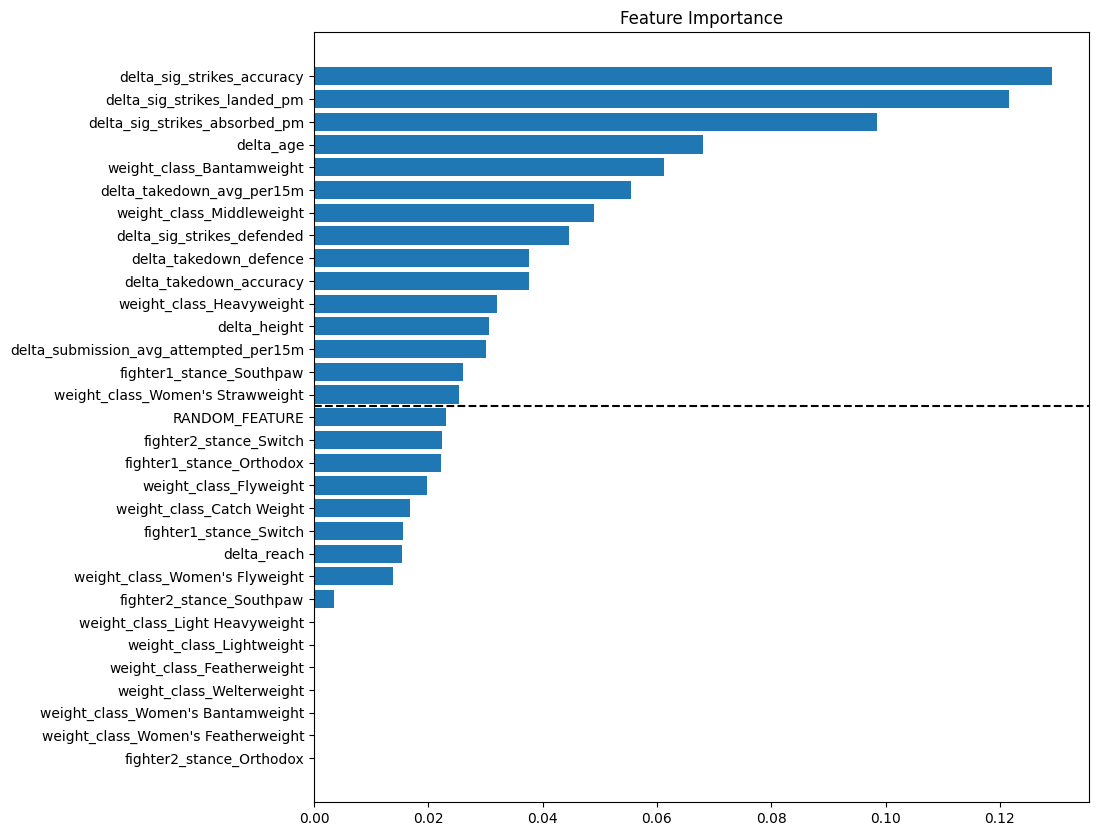

In [ ]:
features = [
    'weight_class', "fighter1_stance", "fighter2_stance",
    'delta_height', 'delta_age', 'delta_reach',
    'delta_sig_strikes_landed_pm', 'delta_sig_strikes_accuracy',
    'delta_sig_strikes_absorbed_pm', 'delta_sig_strikes_defended',
    'delta_takedown_avg_per15m', 'delta_takedown_accuracy',
    'delta_takedown_defence', 'delta_submission_avg_attempted_per15m'
]

categorical_features = ['weight_class', "fighter1_stance", "fighter2_stance"]

xgb_model, error_metrics, numeric_features = test_xgboost(
    df, features, categorical_features, benchmark_random_feature=True
)
print_error_metrics(error_metrics)
plot_feature_importance(xgb_model, numeric_features)

Remove weight class and stance

In [65]:
features = [
    'delta_height', 'delta_age', 'delta_reach',
    'delta_sig_strikes_landed_pm', 'delta_sig_strikes_accuracy',
    'delta_sig_strikes_absorbed_pm', 'delta_sig_strikes_defended',
    'delta_takedown_avg_per15m', 'delta_takedown_accuracy',
    'delta_takedown_defence', 'delta_submission_avg_attempted_per15m'
]

categorical_features = []

xgb_model, error_metrics, numeric_features = test_xgboost(
    df, features, categorical_features, benchmark_random_feature=True
)
print_error_metrics(error_metrics)
plot_feature_importance(xgb_model, numeric_features)

--- Validation set ---
Accuracy: 0.6325678496868476
Confusion Matrix:
 [[143  93]
 [ 83 160]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.61      0.62       236
           1       0.63      0.66      0.65       243

    accuracy                           0.63       479
   macro avg       0.63      0.63      0.63       479
weighted avg       0.63      0.63      0.63       479

--- Test set
Accuracy: 0.6304801670146137
Confusion Matrix:
 [[151  96]
 [ 81 151]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.61      0.63       247
           1       0.61      0.65      0.63       232

    accuracy                           0.63       479
   macro avg       0.63      0.63      0.63       479
weighted avg       0.63      0.63      0.63       479



NameError: name 'NotFittedError' is not defined